
# 03_dataset_and_transforms

In [3]:
import pandas as pd
from PIL import Image
from pathlib import Path
import torch
from torch.utils.data import Dataset
from torchvision import transforms


Training transforms



In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),          # ResNet-50 input size
    transforms.RandomHorizontalFlip(),       # augmentation
    transforms.RandomRotation(10),            # augmentation
    transforms.ToTensor(),                    # convert to tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],           # ImageNet mean
        std=[0.229, 0.224, 0.225]              # ImageNet std
    )
])


#Validation transforms


In [5]:
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [6]:
class ISICSkinDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        """
        csv_file   : processed CSV (train or val)
        image_dir  : directory containing raw images
        transform  : torchvision transforms
        """
        nb_dir = Path.cwd()
        project_root = nb_dir if (nb_dir / 'data').exists() else nb_dir.parent
        csv_file = pd.read_csv(str(project_root / 'data' / 'processed' / 'train' / 'train_binary.csv'))
        image_dir = Path(project_root / 'data' / 'raw' / 'train' / 'images_train')

        self.df = csv_file
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        # Total number of samples
        return len(self.df)

    def __getitem__(self, idx):
        # Get one row from processed CSV
        row = self.df.iloc[idx]

        # Image ID from CSV
        image_id = row["isic_id"]

        # Label (already binary: 0 or 1)
        label = torch.tensor(row["label"], dtype=torch.long)

        # Construct image path
        image_path = f"{self.image_dir}/{image_id}.jpg"

        # Load image
        image = Image.open(image_path).convert("RGB")

        # Apply transforms (if any)
        if self.transform:
            image = self.transform(image)

        return image, label


In [7]:
project_root = Path.cwd().parent

train_dataset = ISICSkinDataset(
    csv_file=project_root/"data/processed/train/train_binary.csv",
    image_dir=project_root/"data/raw/train/images_train",
    transform=train_transforms
)


In [8]:
img, lbl = train_dataset[0]
print(img.shape, lbl)


torch.Size([3, 224, 224]) tensor(0)


In [9]:
val_dataset = ISICSkinDataset(
    csv_file=project_root / "data/processed/val/val_binary.csv",
    image_dir=project_root / "data/raw/val/images_val",
    transform=val_transforms
)


In [10]:
img, lbl = val_dataset[4]
print(img.shape, lbl)

torch.Size([3, 224, 224]) tensor(1)


data loader

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,   # if Windows error → set to 0
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)


In [12]:
images, labels = next(iter(train_loader))

print(images.shape)   # expected: (32, 3, 224, 224)
print(labels.shape)   # expected: (32,)
print(labels[:5])     # sanity check labels


torch.Size([8, 3, 224, 224])
torch.Size([8])
tensor([0, 0, 1, 0, 0])


In [13]:
from torch.utils.data import DataLoader

debug_loader = DataLoader(
    train_dataset,
    batch_size=5,
    shuffle=False,   # IMPORTANT for verification
    num_workers=0
)


In [14]:
images, labels = next(iter(debug_loader))


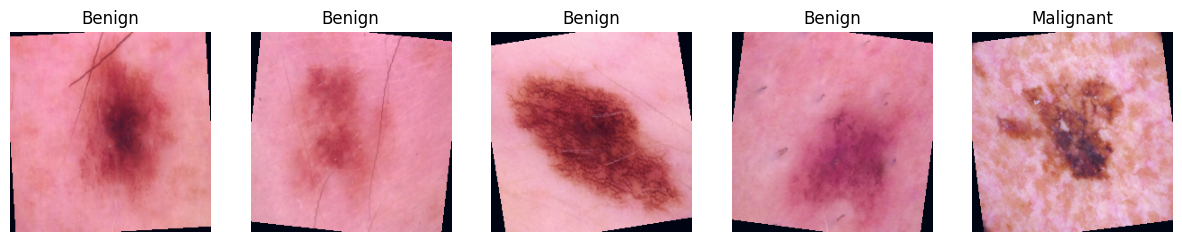

In [15]:
import matplotlib.pyplot as plt
import numpy as np

label_map = {0: "Benign", 1: "Malignant"}

plt.figure(figsize=(15, 4))

for i in range(len(images)):
    img = images[i].permute(1, 2, 0).numpy()   # CHW → HWC
    img = (img - img.min()) / (img.max() - img.min())  # normalize for display

    plt.subplot(1, len(images), i + 1)
    plt.imshow(img)
    plt.title(label_map[int(labels[i])])
    plt.axis("off")

plt.show()
